In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2025-05-20 19:59:27--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.5’

ml-1m.zip.5         100%[===================>]   5.64M  27.0MB/s    in 0.2s    

2025-05-20 19:59:28 (27.0 MB/s) - ‘ml-1m.zip.5’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/movies.dat        
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/ratings.dat       
replace ml-1m/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/README            
replace ml-1m/users.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ml-1m/users.dat         


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate
from sklearn.preprocessing import OneHotEncoder



In [3]:
ratings = pd.read_csv(
    'ml-1m/ratings.dat',
    sep='::',
    engine='python',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp']
)

In [4]:
movies = pd.read_csv(
    'ml-1m/movies.dat',
    sep='::',
    engine='python',
    names=['MovieID', 'Title', 'Genres'],
    encoding='latin-1'  # or 'iso-8859-1'
)

In [5]:
users = pd.read_csv(
    'ml-1m/users.dat',
    sep='::',
    engine='python',
    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
)

In [6]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [7]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [9]:
data = pd.merge(ratings, movies, on='MovieID')
data = pd.merge(data, users, on='UserID')

In [10]:
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   UserID      1000209 non-null  int64 
 1   MovieID     1000209 non-null  int64 
 2   Rating      1000209 non-null  int64 
 3   Timestamp   1000209 non-null  int64 
 4   Title       1000209 non-null  object
 5   Genres      1000209 non-null  object
 6   Gender      1000209 non-null  object
 7   Age         1000209 non-null  int64 
 8   Occupation  1000209 non-null  int64 
 9   Zip-code    1000209 non-null  object
dtypes: int64(6), object(4)
memory usage: 76.3+ MB


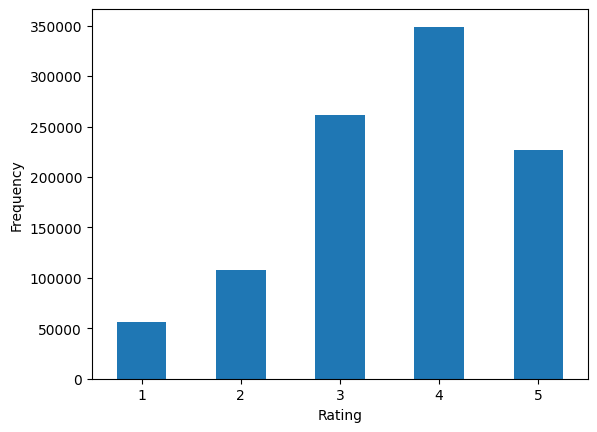

In [12]:
data['Rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [13]:
data.nunique()

,0
UserID,6040
MovieID,3706
Rating,5
Timestamp,458455
Title,3706
Genres,301
Gender,2
Age,7
Occupation,21
Zip-code,3439


In [14]:
age_group_counts = data.groupby('Age').size()
print(age_group_counts)

Age
1      27211
18    183536
25    395556
35    199003
45     83633
50     72490
56     38780
dtype: int64


### Age column is binned, so I will treat each as a respective group i.e '1' will be analyzed as '<18','18' will be '18-24','25' will be '25-34','35' will be '35-44', '45' will be '45-49', '50' will be '50-55', and '56' will be '56+'


In [15]:
## Theory: Time of day may effect genre/rating of movie.

data['Hour'] = pd.to_datetime(data['Timestamp'], unit='s').dt.hour
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,Hour
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067,22
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067,22
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067,22
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067,22
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067,23


In [16]:
#Extract Year out of Title column and update Title column
data['Year'] = data['Title'].str[-5:-1]
data["Year"] = data["Year"].astype(int)
data['Title'] = data['Title'].str[:-7]
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,Hour,Year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,F,1,10,48067,22,1975
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,F,1,10,48067,22,1996
2,1,914,3,978301968,My Fair Lady,Musical|Romance,F,1,10,48067,22,1964
3,1,3408,4,978300275,Erin Brockovich,Drama,F,1,10,48067,22,2000
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,F,1,10,48067,23,1998


In [17]:
#Convert Gender into binary representation
data['Gender'] = data['Gender'].replace({'M': 1, 'F': 0})
data.head()

<ipython-input-17-da4fff86ff7f>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Gender'] = data['Gender'].replace({'M': 1, 'F': 0})


,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,Hour,Year
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,0,1,10,48067,22,1975
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,0,1,10,48067,22,1996
2,1,914,3,978301968,My Fair Lady,Musical|Romance,0,1,10,48067,22,1964
3,1,3408,4,978300275,Erin Brockovich,Drama,0,1,10,48067,22,2000
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,0,1,10,48067,23,1998


In [18]:
#Convert occupation into one-hot representations to avoid ordinal/magnitude assumptions by model later on in development
occupation_dummies = pd.get_dummies(data['Occupation'], prefix='Occupation')
data = pd.concat([data, occupation_dummies], axis=1)
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False
2,1,914,3,978301968,My Fair Lady,Musical|Romance,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False
3,1,3408,4,978300275,Erin Brockovich,Drama,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,0,1,10,48067,...,False,False,False,False,False,False,False,False,False,False


In [19]:
#Extract first 3 numbers from zipcode and convert to one-hot representation. Retains approximate geographic regions which may help model performance, but reduces dimensionality of using full zipcode
data['ZipPrefix'] = data['Zip-code'].str[:3]
zip_dummies = pd.get_dummies(data['ZipPrefix'], prefix='Zip')
data = pd.concat([data.drop(['Zip-code'], axis=1), zip_dummies], axis=1)
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Hour,...,Zip_988,Zip_989,Zip_990,Zip_991,Zip_992,Zip_993,Zip_995,Zip_997,Zip_998,Zip_999
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,0,1,10,22,...,False,False,False,False,False,False,False,False,False,False
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,0,1,10,22,...,False,False,False,False,False,False,False,False,False,False
2,1,914,3,978301968,My Fair Lady,Musical|Romance,0,1,10,22,...,False,False,False,False,False,False,False,False,False,False
3,1,3408,4,978300275,Erin Brockovich,Drama,0,1,10,22,...,False,False,False,False,False,False,False,False,False,False
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,0,1,10,23,...,False,False,False,False,False,False,False,False,False,False


In [20]:
data['ZipPrefix'].nunique()

678

In [21]:
#Converting Genres into one-hot encodings. To get a general understanding of features that effect model performance I will start with one-hot representation,
#but may need to use embeddings to figure out genre relationships, but will use one-hot as preliminary representation/
genre_dummies = data['Genres'].str.get_dummies(sep='|')  # shape: (n_samples, 21)
genre_cols = genre_dummies.columns
data = pd.concat([data, genre_dummies], axis=1)

In [22]:
data

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Hour,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,0,1,10,22,...,0,0,0,0,0,0,0,0,0,0
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,0,1,10,22,...,0,0,0,1,0,0,0,0,0,0
2,1,914,3,978301968,My Fair Lady,Musical|Romance,0,1,10,22,...,0,0,0,1,0,1,0,0,0,0
3,1,3408,4,978300275,Erin Brockovich,Drama,0,1,10,22,...,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,0,1,10,23,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,Weekend at Bernie's,Comedy,1,25,6,2,...,0,0,0,0,0,0,0,0,0,0
1000205,6040,1094,5,956704887,"Crying Game, The",Drama|Romance|War,1,25,6,23,...,0,0,0,0,0,1,0,0,1,0
1000206,6040,562,5,956704746,Welcome to the Dollhouse,Comedy|Drama,1,25,6,23,...,0,0,0,0,0,0,0,0,0,0
1000207,6040,1096,4,956715648,Sophie's Choice,Drama,1,25,6,2,...,0,0,0,0,0,0,0,0,0,0


In [23]:
print('\nTitles with more than 50 tokens:', data[data['Title'].str.len().gt(50)].shape[0])


Titles with more than 50 tokens: 5995


Text(0.5, 0, 'Number of tokens per Title')

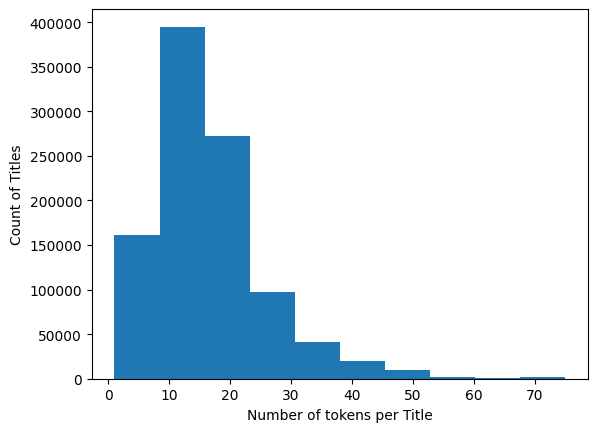

In [24]:
plt.hist(data['Title'].str.len());
plt.ylabel('Count of Titles')
plt.xlabel('Number of tokens per Title')

In [25]:
data['Title'].str.len().max()

75

In [26]:
data['MovieID'].nunique()
data['MovieID'].sort_values()

,MovieID
707867,1
94510,1
439765,1
860768,1
3847,1
...,...
258260,3952
456022,3952
236581,3952
207669,3952


In [27]:
user_avg = data.groupby('UserID')['Rating'].mean().rename('AvgRating')
user_std = data.groupby('UserID')['Rating'].std().fillna(0).rename('RatingStd')
user_genre_counts = data.groupby('UserID')[genre_cols].sum()
user_fav_genre = user_genre_counts.idxmax(axis=1).rename('FavGenre')

In [28]:
user_features = pd.concat([user_avg, user_std, user_fav_genre], axis=1)
user_features

,AvgRating,RatingStd,FavGenre
UserID,,,
1,4.188679,0.680967,Drama
2,3.713178,1.001513,Drama
3,3.901961,0.984985,Comedy
4,4.190476,1.077917,Action
5,3.146465,1.132699,Drama
...,...,...,...
6036,3.302928,1.023684,Drama
6037,3.717822,0.877910,Drama
6038,3.800000,1.105013,Comedy


In [29]:
data = data.merge(user_features, on='UserID', how='left')
data.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Hour,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,AvgRating,RatingStd,FavGenre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest,Drama,0,1,10,22,...,0,0,0,0,0,0,0,4.188679,0.680967,Drama
1,1,661,3,978302109,James and the Giant Peach,Animation|Children's|Musical,0,1,10,22,...,1,0,0,0,0,0,0,4.188679,0.680967,Drama
2,1,914,3,978301968,My Fair Lady,Musical|Romance,0,1,10,22,...,1,0,1,0,0,0,0,4.188679,0.680967,Drama
3,1,3408,4,978300275,Erin Brockovich,Drama,0,1,10,22,...,0,0,0,0,0,0,0,4.188679,0.680967,Drama
4,1,2355,5,978824291,"Bug's Life, A",Animation|Children's|Comedy,0,1,10,23,...,0,0,0,0,0,0,0,4.188679,0.680967,Drama


In [30]:
user_inputdim = (data['UserID'].nunique()) + 1
user_outputdim = int(math.ceil(math.log2(user_inputdim)))
user_inputlength = tf.keras.Input(shape=(1,), name='user_input')

In [31]:
#User Tower
user_embedding = tf.keras.layers.Embedding(
    input_dim= user_inputdim,
    output_dim= user_outputdim)(user_inputlength)
user_embedding = Flatten()(user_embedding)

In [32]:
user_age_input = Input(shape=(1,), name="user_age")
user_occ_input = Input(shape=(21,), name="user_occupation")
user_avg_rating_input = Input(shape=(1,), name="user_avg_rating")

user_features = Concatenate()([
    user_embedding,
    user_age_input,
    user_occ_input,
    user_avg_rating_input
])

Starting with simple input_length of using MovieID

In [33]:
movie_inputdim = (data['MovieID'].nunique()) + 1
movie_outputdim = int(math.ceil(math.log2(user_inputdim)))
movie_inputlength = tf.keras.Input(shape=(1,), name='movie_input')

In [34]:
#Movie Tower
movie_embedding = tf.keras.layers.Embedding(
    input_dim = movie_inputdim,  # size of feature vocabulary
    output_dim = movie_outputdim)(movie_inputlength)
movie_embedding = Flatten()(movie_embedding)

In [35]:
### Add vectorization layer when coming back and doing title embeddings

In [36]:
movie_genre_input = Input(shape=(18,), name="movie_genres_input")  # one-hot
movie_year_input = Input(shape=(1,), name="movie_year_input")

In [37]:
movie_features = Concatenate()([
    movie_embedding,
    movie_year_input,
    movie_genre_input
])

In [38]:
user_encoder = LabelEncoder()
data['UserID_Encoded'] = user_encoder.fit_transform(data['UserID'])

movie_encoder = LabelEncoder()
data['MovieID_Encoded'] = movie_encoder.fit_transform(data['MovieID'])

In [39]:
encoder = OneHotEncoder( handle_unknown='ignore')
occupation_onehot = encoder.fit_transform(data[['Occupation']])

In [40]:
# Extract features and labels for training
# train, test = train_test_split(data, test_size=0.2, random_state=42)
# train_user_ids = train['UserID_Encoded'].values
# train_movie_ids = train['MovieID_Encoded'].values
# train_ratings = train['Rating'].values

# test_user_ids = test['UserID_Encoded'].values
# test_movie_ids = test['MovieID_Encoded'].values
# test_ratings = test['Rating'].values

NameError: name 'train' is not defined

In [41]:
X = data.drop(columns='Rating')
y = data['Rating']

In [42]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Now extract each column as a separate array for model input
train_user_ids = X_train['UserID_Encoded'].values
train_movie_ids = X_train['MovieID_Encoded'].values
train_user_ages = X_train['Age'].values
train_user_occs = encoder.fit_transform(X_train[['Occupation']]).astype('float32')
train_user_avg_ratings = X_train['AvgRating'].values
train_movie_genres = X_train[genre_cols].to_numpy().astype('float32')
train_movie_years = X_train['Year'].values
train_ratings = y_train.values

# Repeat for test
test_user_ids = X_test['UserID_Encoded'].values
test_movie_ids = X_test['MovieID_Encoded'].values
test_user_ages = X_test['Age'].values
test_user_occs =encoder.fit_transform(X_test[['Occupation']]).astype('float32')
test_user_avg_ratings = X_test['AvgRating'].values
test_movie_genres = X_test[genre_cols].to_numpy().astype('float32')
test_movie_years = X_test['Year'].values
test_ratings = y_test.values


In [43]:
# Number of unique users and movies
num_users = data['UserID'].nunique()
num_movies = data['MovieID'].nunique()
embedding_dim = 50  # Number of dimensions for the embedding


combined = Concatenate()([user_features, movie_features])
x = Dense(128, activation='relu')(combined)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='linear')(x)



early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create the model
model = Model(inputs=[
    user_inputlength,
    movie_inputlength,
    user_age_input,
    user_occ_input,
    user_avg_rating_input,
    movie_year_input,
    movie_genre_input
], outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse','mae'])

# Train the model

history = model.fit(
    x=[
        train_user_ids,
        train_movie_ids,
        train_user_ages,
        train_user_occs,
        train_user_avg_ratings,
        train_movie_years,
        train_movie_genres
    ],
    y=train_ratings,
    epochs=5,
    batch_size=64,
    validation_data=(
        [
            test_user_ids,
            test_movie_ids,
            test_user_ages,
            test_user_occs,
            test_user_avg_ratings,
            test_movie_years,
            test_movie_genres
        ],
        test_ratings
    ),
    callbacks=[early_stopping]
)


Epoch 1/5
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - loss: 19.2242 - mae: 1.5959 - mse: 19.2242 - val_loss: 1.0516 - val_mae: 0.8461 - val_mse: 1.0516
Epoch 2/5
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 1.5099 - mae: 0.9479 - mse: 1.5099 - val_loss: 0.9652 - val_mae: 0.8029 - val_mse: 0.9652
Epoch 3/5
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - loss: 0.9699 - mae: 0.7800 - mse: 0.9699 - val_loss: 0.8899 - val_mae: 0.7629 - val_mse: 0.8899
Epoch 4/5
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - loss: 0.8489 - mae: 0.7295 - mse: 0.8489 - val_loss: 0.8373 - val_mae: 0.7271 - val_mse: 0.8373
Epoch 5/5
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - loss: 0.8260 - mae: 0.7174 - mse: 0.8260 - val_loss: 0.8507 - val_mae: 0.7240 - val_mse: 0.8507


In [44]:
test_loss = model.evaluate(
    x=[
        test_user_ids,
        test_movie_ids,
        test_user_ages,
        test_user_occs,
        test_user_avg_ratings,
        test_movie_years,
        test_movie_genres
    ],
    y=test_ratings
)


6252/6252 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.8367 - mae: 0.7265 - mse: 0.8367


In [45]:
test_loss

[0.8373090028762817, 0.8373090028762817, 0.727051317691803]

In [46]:
# Make predictions on the full test set
test_predictions = model.predict([test_user_ids,
                                  test_movie_ids,
                                  test_user_ages,
                                  test_user_occs,
                                  test_user_avg_ratings,
                                  test_movie_years,
                                  test_movie_genres])

# Add the original user IDs, movie IDs, actual ratings, and predicted ratings to a DataFrame, and convert back to original movie and user IDs
test_results = pd.DataFrame({
    'original_user_id': user_encoder.inverse_transform(test_user_ids),
    'original_movie_id': movie_encoder.inverse_transform(test_movie_ids),
    'actual_rating': test_ratings,
    'predicted_rating': test_predictions.flatten()
})

6252/6252 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step


In [47]:
test_results

,original_user_id,original_movie_id,actual_rating,predicted_rating
0,5412,2683,2,3.462195
1,5440,904,5,4.732130
2,368,3717,4,3.263480
3,425,1721,4,3.335382
4,4942,3697,1,2.595803
...,...,...,...,...
200037,4505,1396,4,4.294880
200038,2934,724,1,2.779017
200039,2572,968,5,3.850433
200040,1748,1625,3,3.565034


In [48]:
test_results['rating_difference'] = abs(test_results['actual_rating'] - test_results['predicted_rating'])

# Filter by a specific user ID, for example:
filter_user_id = 368


filtered_results = test_results[test_results['original_user_id'] == filter_user_id]


filtered_results_sorted = filtered_results.sort_values(by='rating_difference')

# Display sorted results
print(f"Predictions for user {filter_user_id}, ordered by closest rating difference:")
filtered_results_sorted

Predictions for user 368, ordered by closest rating difference:


,original_user_id,original_movie_id,actual_rating,predicted_rating,rating_difference
54055,368,300,4,3.996606,0.003394
195384,368,3841,3,3.019038,0.019038
100282,368,1396,4,3.956399,0.043601
27995,368,3159,4,3.948287,0.051713
179252,368,3753,4,3.909768,0.090232
...,...,...,...,...,...
10156,368,1552,2,3.426317,1.426317
34643,368,193,1,2.450022,1.450022
46767,368,3946,1,2.481026,1.481026
136453,368,1385,2,3.560187,1.560187


In [49]:
test_results['rating_difference'].mean()

np.float64(0.7270518073704694)

In [53]:
num_movies = data['MovieID'].nunique()
all_movie_ids = np.arange(num_movies)
ex_user_id = 368

In [55]:
user_input_across_movies = np.full_like(all_movie_ids, ex_user_id)

In [57]:
scores = model.predict([
    user_input_across_movies,
    all_movie_ids,
    test_user_ages,
    test_user_occs,
    test_user_avg_ratings,
    test_movie_years,
    test_movie_genres])

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 3706, 3706, 200042, 200042, 200042, 200042, 200042
